# モデル学習

## Library Import

In [65]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

import datetime as dt

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [66]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../output/intermediate_file/'
model_path = '../output/model/'
oof_path = '../output/oof/'
fi_path = '../output/fi/'

# スクリプトのバージョン指定
fe_ver = 2
training_ver = 2
run_ver = 3 # モデル変更のない特徴量の更新についてはこちらで管理

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [67]:
train_df = pd.read_csv(f'{intermediate_path}train_df_fe_v{fe_ver}.csv')

In [68]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [69]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

In [70]:
# tag_prefixes = (
#     '土地価格_',
#     '建物構造・性能_',
#     '建物設備（給排水・インフラ）_',
#     '立地プレミアム_',
#     '環境プレミアム_',
#     '専有部分設備_',
#     '用途・投資セグメント_売買ステータス_',
#     '用途・投資セグメント_不動産の証明書・性能評価_',
# )

# tag_cols = [
#     c for c in train_df.columns
#     if c.startswith(tag_prefixes)
# ]

In [71]:
# remove_cols = ['count_neighbors_1000m', 'door_to_station_min_log', 'tochi_area_log', 'shikichi_area_log'] + tag_cols
# fe_cols = [c for c in fe_cols if c not in remove_cols]

#### カテゴリ型へ変更

In [72]:
cat_cols = ['building_category', 'land_toshi', 'land_area_kind', 'land_youto', 'building_land_chimoku',
            'land_road_cond', 'building_area_kind', 'access_zone'
]

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [73]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()
train_df[obj_cols] = train_df[obj_cols].astype('category')

## モデルの学習

In [74]:
house_idx = train_df['building_category'] == 'house'
non_house_idx = ~house_idx

train_df_house = train_df[house_idx]
train_df_all = train_df[non_house_idx]

all_base_cols = fe_cols.copy()
all_low_cols = fe_cols.copy()
house_base_cols = fe_cols.copy()
house_low_cols = fe_cols.copy()

# drop_cols = [
#     'rosen_name1', 'rosen_name2', 'eki_name1', 'eki_name2',
#     'Prefecture name', 'City/town/village name'
# ]

# # fe_cols 内に存在するものだけ残す
# house_base_cols = [c for c in fe_cols if c not in drop_cols]
# house_low_cols  = [c for c in fe_cols if c not in drop_cols]

In [75]:
LOW_PRICE_TH_ALL = 10_000_000  # 低価格の閾値（1,000万円）
LOW_PRICE_TH_HOUSE = 20_000_000  # 低価格の閾値（1,000万円）
year_col = 'target_year'

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 100,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

low_params = {
    'num_leaves': 64,
    'min_child_samples': 30,
}

In [76]:
mono_map = {
    # 単調増加
    "land_theoretical_price_weighted": 1,
    "land_theoretical_price": 1,
    "log_land_price": 1,
    "log_weighted_land_price_3": 1,
    "mean_price_500m_log": 1,
    "mean_price_1000m_log": 1,
    "mean_price_2000m_log": 1,
    "mean_price_500m_mansion_log": 1,
    "mean_price_1000m_mansion_log": 1,
    "mean_price_2000m_mansion_log": 1,
    "mean_price_500m_house_log": 1,
    "mean_price_1000m_house_log": 1,
    "mean_price_2000m_house_log": 1,
    # "senyu_area_log": 1,
    # "nobeyuka_area_log": 1,

    # 単調減少
    "built_diff": -1,
    "door_to_station_min_log": -1,
    # "distance_to_landpoint_m": -1,
    # "listing_months": -1,
}

#### 関数

In [77]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))

In [78]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def predict_with_base_and_low(
    base_model, low_model,
    X_base, X_low,
    LOW_PRICE_TH=10_000_000,
    r_low=0.5,
    r_base=1.5,
    gap_ratio=2.0,   # ←改善案: まず下げる（反応を鈍らせない）
    k=8.0,
    w_max=0.7,
    return_parts=True,
    w_eps=1e-6,
):
    base_pred_log = base_model.predict(X_base)
    low_pred_log  = low_model.predict(X_low)

    th_log = np.log(LOW_PRICE_TH)
    low_apply_log  = th_log + np.log(r_low)
    base_range_log = th_log + np.log(r_base)
    gap_th = np.log(gap_ratio)

    # lowが「超低価格」を示すほど w を上げる
    w_low_raw = sigmoid(-k * (low_pred_log - low_apply_log))

    # 改善案：baseが閾値近傍以下なら low を混ぜやすく（misassign救済）
    w_price = sigmoid(-k * (base_pred_log - th_log))
    w_low = np.maximum(w_low_raw, w_price)

    # baseが過剰っぽいほど w を上げる（ただし低価格帯限定で効かせる）
    gap = base_pred_log - low_pred_log
    w_gap = sigmoid(k * (gap - gap_th))
    price_gate = sigmoid(-k * (base_pred_log - base_range_log))
    w_gap = w_gap * price_gate

    # baseが高額なら w を落とす（lowの暴走を止める）
    w_allow = sigmoid(-k * (base_pred_log - base_range_log))

    w = np.clip(np.maximum(w_low, w_gap) * w_allow, 0.0, w_max)

    pred_log = (1 - w) * base_pred_log + w * low_pred_log

    if not return_parts:
        return pred_log

    used_low = (w > w_eps)
    driver = np.where(w_low >= w_gap, "low/price", "gap")  # wの主因（簡易）

    return pred_log, base_pred_log, low_pred_log, w, used_low, w_low, w_gap, w_allow, gap, driver


In [79]:
def make_monotone_constraints(feature_names):
    return [mono_map.get(col, 0) for col in feature_names]

In [80]:
def _infer_te_source_col(te_col: str) -> str:
    # "xxx_te" -> "xxx"
    return te_col[:-3] if te_col.endswith("_te") else te_col

def fit_target_encoding_map(
    s_cat: pd.Series,
    y: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
) -> tuple[pd.Series, float]:
    """
    1列のカテゴリ s_cat をターゲット y で target encoding するための mapping を作る。
    smoothing: 大きいほど全体平均に寄る（過学習防止）
    """
    s_cat = s_cat.astype("object")
    y = y.astype(float)

    prior = float(y.mean())

    stats = (
        pd.DataFrame({"cat": s_cat, "y": y})
          .groupby("cat")["y"]
          .agg(["count", "mean"])
    )

    # count が小さいカテゴリは prior に寄せる（smoothing + min_samples_leaf）
    count = stats["count"].astype(float)
    mean  = stats["mean"].astype(float)

    # smoothing 係数（一般的な ridge-like smoothing）
    # enc = (count*mean + smoothing*prior) / (count + smoothing)
    enc = (count * mean + smoothing * prior) / (count + smoothing)

    # さらに min_samples_leaf 未満は prior へ
    if min_samples_leaf > 1:
        enc[count < min_samples_leaf] = prior

    return enc, prior

def apply_target_encoding(
    s_cat: pd.Series,
    mapping: pd.Series,
    prior: float,
) -> pd.Series:
    s_cat = s_cat.astype("object")
    return s_cat.map(mapping).fillna(prior).astype(float)

def recompute_te_for_fold(
    train_df: pd.DataFrame,
    tr_idx: pd.Index,
    apply_idx_list: list[pd.Index],
    te_cols: list[str],
    y_tr: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
    verbose: bool = True,
) -> dict:
    """
    te_cols（例: eki_name1_te）の各列について、
    学習fold（tr_idx）だけでTEをfitし、apply_idx_list の各Indexへ適用する。

    返り値: {te_col: {"src_col":..., "mapping":..., "prior":...}} （必要なら保存用）
    """
    te_meta = {}

    for te_col in te_cols:
        src_col = _infer_te_source_col(te_col)
        if src_col not in train_df.columns:
            if verbose:
                print(f"[WARN] TE元列が見つからないためスキップ: {te_col} (src={src_col})")
            continue

        mapping, prior = fit_target_encoding_map(
            train_df.loc[tr_idx, src_col],
            y_tr.loc[tr_idx],
            smoothing=smoothing,
            min_samples_leaf=min_samples_leaf,
        )

        # 各適用先（train/val/ho など）へ適用
        for idx in apply_idx_list:
            train_df.loc[idx, te_col] = apply_target_encoding(
                train_df.loc[idx, src_col],
                mapping,
                prior
            ).values

        te_meta[te_col] = {"src_col": src_col, "mapping": mapping, "prior": prior}

    return te_meta

In [81]:
def run_cv_with_low_model(
    train_df,
    base_cols,
    low_cols,
    target_col,
    year_col,
    base_params,
    low_params,
    low_price_th=10_000_000,
    n_splits=5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
    w_eps: float = 1e-6,          # 混合したとみなす閾値
):
    y = train_df[target_col].astype(float)
    y_log = np.log(y)

    mask_train_cv = train_df[year_col] <= 2021
    mask_holdout  = train_df[year_col] == 2022

    idx_cv = train_df.index[mask_train_cv]
    idx_ho = train_df.index[mask_holdout]

    X_cv_base = train_df.loc[idx_cv, base_cols]
    y_cv_log  = y_log.loc[idx_cv]
    groups_cv = train_df.loc[idx_cv, 'building_id']

    y_ho = y.loc[idx_ho]

    print(f'CV 用データ: {len(idx_cv)} 行')
    print(f'Holdout 用データ (2022): {len(idx_ho)} 行\n')

    # ===== OOF：最終 / base / low + 診断値 =====
    oof_pred_log      = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_pred_log_base = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_pred_log_low  = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_w             = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_used_low      = pd.Series(False,  index=train_df.index, dtype=bool)
    oof_driver        = pd.Series(pd.NA,  index=train_df.index, dtype="string")

    # 任意：分析に便利（軽い）
    oof_w_low   = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_w_gap   = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_w_allow = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_gap     = pd.Series(np.nan, index=train_df.index, dtype=float)

    # ===== HO：fold平均（used_lowは採用率）=====
    ho_pred_log_accum      = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_pred_log_base_accum = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_pred_log_low_accum  = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_w_accum             = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_used_low_votes      = pd.Series(0.0, index=idx_ho, dtype=float)  # w>w_eps の割合

    fi_list_base = []
    fi_list_low  = []

    gkf = GroupKFold(n_splits=n_splits)
    print('=== GroupKFold CV 開始 ===')

    te_cols_base = [c for c in base_cols if c.endswith("_te")]
    te_cols_low  = [c for c in low_cols  if c.endswith("_te")]
    te_cols_all  = sorted(set(te_cols_base + te_cols_low))

    for fold, (tr_idx_local, va_idx_local) in enumerate(gkf.split(X_cv_base, y_cv_log, groups_cv), 1):
        tr_idx = idx_cv[tr_idx_local]
        va_idx = idx_cv[va_idx_local]

        # --- fold内TE再計算 ---
        if te_cols_all:
            _ = recompute_te_for_fold(
                train_df=train_df,
                tr_idx=tr_idx,
                apply_idx_list=[tr_idx, va_idx, idx_ho],
                te_cols=te_cols_all,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=(fold == 1),
            )

        # ===== base fit =====
        X_tr_base = train_df.loc[tr_idx, base_cols]
        y_tr_log  = y_log.loc[tr_idx]
        monotone_constraints_base = make_monotone_constraints(X_tr_base.columns)

        base_model = lgb.LGBMRegressor(
            **base_params, monotone_constraints=monotone_constraints_base
        )
        base_model.fit(X_tr_base, y_tr_log)

        # ===== low fit（学習サンプル抽出は真値でOK）=====
        mask_tr_low = (y.loc[tr_idx] <= low_price_th)
        tr_idx_low = tr_idx[mask_tr_low]

        X_tr_low = train_df.loc[tr_idx_low, low_cols]
        y_tr_low_log = y_log.loc[tr_idx_low]
        monotone_constraints_low = make_monotone_constraints(X_tr_low.columns)

        low_model = lgb.LGBMRegressor(
            **low_params, monotone_constraints=monotone_constraints_low
        )
        low_model.fit(X_tr_low, y_tr_low_log)

        # ===== OOF predict（分解）=====
        X_va_base = train_df.loc[va_idx, base_cols]
        X_va_low  = train_df.loc[va_idx, low_cols]

        (va_final_log, va_base_log, va_low_log,
         va_w, va_used_low, va_w_low, va_w_gap, va_w_allow, va_gap, va_driver) = predict_with_base_and_low(
            base_model, low_model, X_va_base, X_va_low,
            LOW_PRICE_TH=low_price_th,
            return_parts=True,
            w_eps=w_eps,
        )

        oof_pred_log.loc[va_idx]      = va_final_log
        oof_pred_log_base.loc[va_idx] = va_base_log
        oof_pred_log_low.loc[va_idx]  = va_low_log
        oof_w.loc[va_idx]             = va_w
        oof_used_low.loc[va_idx]      = va_used_low
        oof_driver.loc[va_idx]        = va_driver

        oof_w_low.loc[va_idx]   = va_w_low
        oof_w_gap.loc[va_idx]   = va_w_gap
        oof_w_allow.loc[va_idx] = va_w_allow
        oof_gap.loc[va_idx]     = va_gap

        # ===== HO predict（分解、fold平均）=====
        X_ho_base_fold = train_df.loc[idx_ho, base_cols]
        X_ho_low_fold  = train_df.loc[idx_ho, low_cols]

        (ho_final_log, ho_base_log, ho_low_log,
         ho_w, ho_used_low, *_rest) = predict_with_base_and_low(
            base_model, low_model, X_ho_base_fold, X_ho_low_fold,
            LOW_PRICE_TH=low_price_th,
            return_parts=True,
            w_eps=w_eps,
        )

        ho_pred_log_accum      += ho_final_log / n_splits
        ho_pred_log_base_accum += ho_base_log  / n_splits
        ho_pred_log_low_accum  += ho_low_log   / n_splits
        ho_w_accum             += ho_w         / n_splits
        ho_used_low_votes      += ho_used_low.astype(float) / n_splits

        # ===== fold MAPE =====
        fold_mape = mape(y.loc[va_idx], np.exp(va_final_log))
        print(f'Fold {fold}: val MAPE={fold_mape:.4f}')

        # ===== FI =====
        fi_list_base.append(pd.DataFrame({
            'feature': base_cols,
            'importance': base_model.booster_.feature_importance(importance_type='gain'),
            'fold': fold
        }))
        fi_list_low.append(pd.DataFrame({
            'feature': low_cols,
            'importance': low_model.booster_.feature_importance(importance_type='gain'),
            'fold': fold
        }))

    print('=== CV 完了 ===\n')

    return (
        y, y_ho,
        oof_pred_log, ho_pred_log_accum,
        fi_list_base, fi_list_low,
        # 追加返り値（分解）
        oof_pred_log_base, oof_pred_log_low, oof_w, oof_used_low, oof_driver,
        oof_w_low, oof_w_gap, oof_w_allow, oof_gap,
        ho_pred_log_base_accum, ho_pred_log_low_accum, ho_w_accum, ho_used_low_votes,
    )


#### house以外モデル

In [82]:
(
    y_all, y_ho_all,
    oof_pred_log_all, ho_pred_log_all,
    fi_list_all_base, fi_list_all_low,

    # --- 追加（分解）---
    oof_pred_log_all_base, oof_pred_log_all_low,
    oof_w_all, oof_used_low_all, oof_driver_all,
    oof_w_low_all, oof_w_gap_all, oof_w_allow_all, oof_gap_all,

    ho_pred_log_all_base, ho_pred_log_all_low,
    ho_w_all, ho_used_low_rate_all,
) = run_cv_with_low_model(
    train_df=train_df_all,
    base_cols=all_base_cols,
    low_cols=all_low_cols,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_ALL,
    base_params=base_params,
    low_params=low_params,
)


CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33375
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 337
[LightGBM] [Info] Start training from score 16.904156
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a lar

In [83]:
# OOF / HO スコア
oof_mask_valid = ~np.isnan(oof_pred_log_all)
y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all[oof_mask_valid])
oof_mape_all = mape(y_oof, oof_pred_all)

ho_pred_all = np.exp(ho_pred_log_all)
ho_mape_all = mape(y_ho_all, ho_pred_all)

print(f'OOF MAPE (2019–2021) : {oof_mape_all:.6f}')
print(f'2022 hold-out MAPE  : {ho_mape_all:.6f}')

OOF MAPE (2019–2021) : 0.141107
2022 hold-out MAPE  : 0.126315


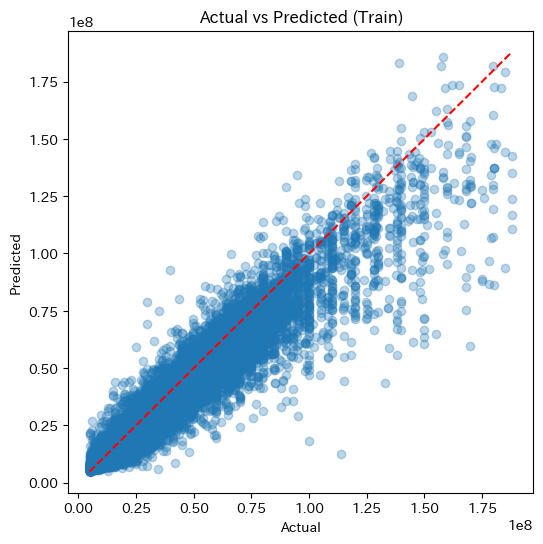

In [84]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_all, ho_pred_all, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_all.min(), ho_pred_all.min())
max_val = max(y_ho_all.max(), ho_pred_all.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

In [85]:
idx_cv = train_df_all.index[train_df_all[year_col] <= 2021]
idx_ho = train_df_all.index[train_df_all[year_col] == 2022]

def nan_rate(s): 
    return float(pd.isna(s.loc[idx_cv]).mean())

print("OOF final NaN rate:", nan_rate(oof_pred_log_all))
print("OOF base  NaN rate:", nan_rate(oof_pred_log_all_base))
print("OOF low   NaN rate:", nan_rate(oof_pred_log_all_low))
print("OOF w     NaN rate:", nan_rate(oof_w_all))
print("OOF used_low True rate:", float(oof_used_low_all.loc[idx_cv].mean()))
print("OOF driver NaN rate:", float(pd.isna(oof_driver_all.loc[idx_cv]).mean()))

OOF final NaN rate: 0.0
OOF base  NaN rate: 0.0
OOF low   NaN rate: 0.0
OOF w     NaN rate: 0.0
OOF used_low True rate: 0.8741894131257231
OOF driver NaN rate: 0.0


In [86]:
lhs = oof_pred_log_all.loc[idx_cv]
rhs = (1 - oof_w_all.loc[idx_cv]) * oof_pred_log_all_base.loc[idx_cv] + oof_w_all.loc[idx_cv] * oof_pred_log_all_low.loc[idx_cv]
diff = (lhs - rhs).abs()

print("blend consistency |max|:", float(diff.max()))
print("blend consistency |p99|:", float(diff.quantile(0.99)))
print("blend consistency |median|:", float(diff.median()))

blend consistency |max|: 0.0
blend consistency |p99|: 0.0
blend consistency |median|: 0.0


In [87]:
print("w min/max:", float(oof_w_all.loc[idx_cv].min()), float(oof_w_all.loc[idx_cv].max()))

w min/max: 5.463811913303999e-13 0.7


In [88]:
w_eps = 1e-6  # あなたの設定に合わせる
flag_from_w = (oof_w_all.loc[idx_cv] > w_eps)
flag_saved  = oof_used_low_all.loc[idx_cv].astype(bool)

mismatch = (flag_from_w != flag_saved).mean()
print("used_low mismatch rate:", float(mismatch))

used_low mismatch rate: 0.0


In [89]:
y_cv = y_all.loc[idx_cv]
pred_final = np.exp(oof_pred_log_all.loc[idx_cv])
pred_base  = np.exp(oof_pred_log_all_base.loc[idx_cv])

ratio_final = pred_final / y_cv
ratio_base  = pred_base  / y_cv

df_chk = pd.DataFrame({
    "ratio_final": ratio_final,
    "ratio_base": ratio_base,
    "w": oof_w_all.loc[idx_cv],
    "used_low": oof_used_low_all.loc[idx_cv].values,
    "driver": oof_driver_all.loc[idx_cv].values,
})

display(df_chk.groupby("used_low").agg(
    n=("w","size"),
    over15_final=("ratio_final", lambda s: (s>1.5).mean()),
    over15_base =("ratio_base",  lambda s: (s>1.5).mean()),
    w_median=("w","median"),
))

,n,over15_final,over15_base,w_median
used_low,,,,
False,20119,0.013122,0.013122,1.549822e-07
True,139796,0.022368,0.028627,3.962676e-03


In [90]:
LOW_TH = LOW_PRICE_TH_ALL

df_low = pd.DataFrame({
    "y": y_cv,
    "ratio_final": ratio_final,
    "w": oof_w_all.loc[idx_cv],
    "w_low": oof_w_low_all.loc[idx_cv],
    "w_gap": oof_w_gap_all.loc[idx_cv],
    "w_allow": oof_w_allow_all.loc[idx_cv],
    "driver": oof_driver_all.loc[idx_cv],
})

df_low = df_low[df_low["y"] <= LOW_TH]

display(df_low.agg({
    "w": ["mean","median"],
    "w_low": ["mean","median"],
    "w_gap": ["mean","median"],
    "w_allow": ["mean","median"],
    "ratio_final": ["mean","median", lambda s: (s>1.5).mean()],
}))


,w,w_low,w_gap,w_allow,ratio_final
mean,0.531261,0.639247,0.026922,0.929851,1.148863
median,0.700000,0.723815,0.009520,0.985330,1.077326
<lambda>,NaN,NaN,NaN,NaN,0.094892


In [91]:
w_small = 0.05  # 例：ほぼbaseとみなす閾値

df_eval = pd.DataFrame({
    "y": y_cv,
    "pred_base": pred_base,
    "w": oof_w_all.loc[idx_cv],
    "ratio_final": ratio_final,
    "ratio_base": ratio_base,
})

# 定義A：真値で低価格なのに base寄り（原因究明）
mis_y = df_eval[(df_eval["y"] <= LOW_TH) & (df_eval["w"] < w_small)]

# 定義B：base予測で低価格なのに base寄り（運用改善に直結）
mis_p = df_eval[(df_eval["pred_base"] <= LOW_TH) & (df_eval["w"] < w_small)]

print("mis_y:", len(mis_y), " / mis_p:", len(mis_p))


mis_y: 578  / mis_p: 0


In [92]:
# 予測が全部埋まっているか
print("HO final NaN:", float(pd.isna(ho_pred_log_all).mean()))
print("HO base  NaN:", float(pd.isna(ho_pred_log_all_base).mean()))
print("HO low   NaN:", float(pd.isna(ho_pred_log_all_low).mean()))
print("HO w     NaN:", float(pd.isna(ho_w_all).mean()))

print("HO used_low_rate mean:", float(ho_used_low_rate_all.mean()))

HO final NaN: 0.0
HO base  NaN: 0.0
HO low   NaN: 0.0
HO w     NaN: 0.0
HO used_low_rate mean: 0.8360572072874014


In [ ]:
# 参考：どういう物件か眺めるだけ
train_df_mis_y = train_df_all.loc[mis_y.index]

train_df_mis_y[
    ["City/town/village name", "year_built", "senyu_area", "floor", target_col]
].head()

#### houseモデル

In [93]:
(
    y_house, y_ho_house,
    oof_pred_log_house, ho_pred_log_house,
    fi_list_house_base, fi_list_house_low,

    oof_pred_log_house_base, oof_pred_log_house_low,
    oof_w_house, oof_used_low_house, oof_driver_house,
    oof_w_low_house, oof_w_gap_house, oof_w_allow_house, oof_gap_house,

    ho_pred_log_house_base, ho_pred_log_house_low,
    ho_w_house, ho_used_low_rate_house,
) = run_cv_with_low_model(
    train_df=train_df_house,
    base_cols=house_base_cols,
    low_cols=house_low_cols,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_HOUSE,
    base_params=base_params,
    low_params=low_params,
)


CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32023
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 300
[LightGBM] [Info] Start training from score 16.782947
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a larg

In [94]:
# OOF / HO スコア
oof_mask_valid = ~np.isnan(oof_pred_log_house)
y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house[oof_mask_valid])
oof_mape_house = mape(y_oof, oof_pred_house)

ho_pred_house = np.exp(ho_pred_log_house)
ho_mape_house = mape(y_ho_house, ho_pred_house)

print(f'OOF MAPE (2019–2021) : {oof_mape_house:.6f}')
print(f'2022 hold-out MAPE  : {ho_mape_house:.6f}')

OOF MAPE (2019–2021) : 0.191325
2022 hold-out MAPE  : 0.177949


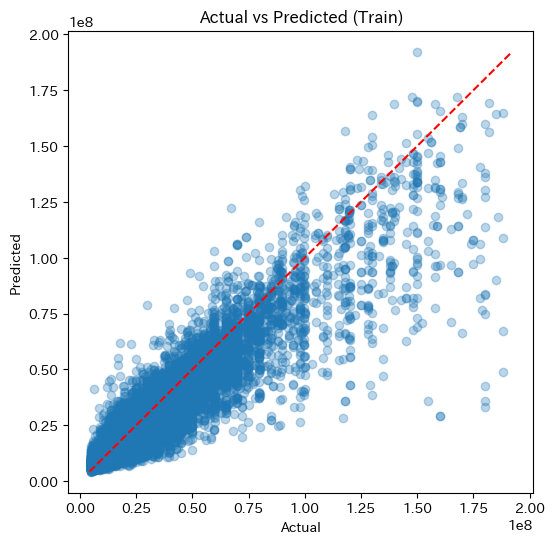

In [95]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_house, ho_pred_house, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_house.min(), ho_pred_house.min())
max_val = max(y_ho_house.max(), ho_pred_house.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

In [96]:
idx_cv_house = train_df_house.index[train_df_house[year_col] <= 2021]

lhs = oof_pred_log_house.loc[idx_cv_house]
rhs = (1 - oof_w_house.loc[idx_cv_house]) * oof_pred_log_house_base.loc[idx_cv_house] + oof_w_house.loc[idx_cv_house] * oof_pred_log_house_low.loc[idx_cv_house]
diff = (lhs - rhs).abs()

print("blend consistency |max|:", float(diff.max()))
print("blend consistency |p99|:", float(diff.quantile(0.99)))
print("w min/max:", float(oof_w_house.loc[idx_cv_house].min()), float(oof_w_house.loc[idx_cv_house].max()))
print("used_low rate:", float(oof_used_low_house.loc[idx_cv_house].mean()))

blend consistency |max|: 0.0
blend consistency |p99|: 0.0
w min/max: 3.532213578454625e-10 0.7
used_low rate: 0.9877755738664663


In [97]:
y_cv = y_house.loc[idx_cv_house]
pred_final = np.exp(oof_pred_log_house.loc[idx_cv_house])
pred_base  = np.exp(oof_pred_log_house_base.loc[idx_cv_house])

ratio_final = pred_final / y_cv
ratio_base  = pred_base / y_cv

df_chk = pd.DataFrame({
    "ratio_final": ratio_final,
    "ratio_base": ratio_base,
    "w": oof_w_house.loc[idx_cv_house],
    "used_low": oof_used_low_house.loc[idx_cv_house].values,
    "driver": oof_driver_house.loc[idx_cv_house].values,
})

display(df_chk.groupby("used_low").agg(
    n=("w","size"),
    over15_final=("ratio_final", lambda s: (s>1.5).mean()),
    over15_base =("ratio_base",  lambda s: (s>1.5).mean()),
    median_final=("ratio_final","median"),
    w_median=("w","median"),
))


,n,over15_final,over15_base,median_final,w_median
used_low,,,,,
False,1399,0.051465,0.051465,0.996772,1.547544e-07
True,113044,0.044257,0.052820,0.968128,5.517940e-01


In [98]:
LOW_TH = LOW_PRICE_TH_HOUSE
w_small = 0.05

df_eval = pd.DataFrame({
    "y": y_cv,
    "pred_base": pred_base,
    "w": oof_w_house.loc[idx_cv_house],
    "ratio_final": ratio_final,
    "ratio_base": ratio_base,
})

mis_y = df_eval[(df_eval["y"] <= LOW_TH) & (df_eval["w"] < w_small)]
mis_p = df_eval[(df_eval["pred_base"] <= LOW_TH) & (df_eval["w"] < w_small)]

print("misassign by y:", len(mis_y))
print("misassign by base_pred:", len(mis_p))


misassign by y: 349
misassign by base_pred: 0


In [99]:
X_cv_house_base = train_df_house.loc[idx_cv_house, house_base_cols]

num_cols = [c for c in [
    "senyu_area", "built_diff", "year_built",
    "door_to_station_min_clip",
    "weighted_land_price_3",
    "building_land_area_log",
    "snapshot_land_area_log",
] if c in X_cv_house_base.columns]

def summarize_num(X, idx_all, idx_bad, cols):
    rows = []
    for c in cols:
        s_all = X.loc[idx_all, c]
        s_bad = X.loc[idx_bad, c]
        rows.append({
            "col": c,
            "all_median": s_all.median(),
            "bad_median": s_bad.median(),
            "all_p10": s_all.quantile(0.10),
            "bad_p10": s_bad.quantile(0.10),
            "all_p90": s_all.quantile(0.90),
            "bad_p90": s_bad.quantile(0.90),
            "all_nan": s_all.isna().mean(),
            "bad_nan": s_bad.isna().mean(),
        })
    return pd.DataFrame(rows).sort_values("bad_nan", ascending=False)

display(summarize_num(X_cv_house_base, idx_cv_house, mis_y.index, num_cols))


,col,all_median,bad_median,all_p10,bad_p10,all_p90,bad_p90,all_nan,bad_nan
0,built_diff,26.0,23.0,7.0,6.0,45.0,43.8,0.023409,0.045845
1,year_built,199412.0,199803.0,197505.0,197803.6,201412.0,201705.0,0.001346,0.000000


In [100]:
cat_cols = [c for c in [
    "building_category",
    "Prefecture name",
    "City/town/village name",
] if c in X_cv_house_base.columns]

def summarize_cat_lift(X, idx_all, idx_bad, col, topk=20):
    vc_all = X.loc[idx_all, col].value_counts(normalize=True, dropna=False)
    vc_bad = X.loc[idx_bad, col].value_counts(normalize=True, dropna=False)
    lift = (vc_bad / vc_all).sort_values(ascending=False).head(topk)
    out = pd.DataFrame({
        "value": lift.index,
        "lift": lift.values,
        "bad_rate": vc_bad.reindex(lift.index).values,
        "all_rate": vc_all.reindex(lift.index).values,
    })
    out["col"] = col
    return out

if cat_cols:
    display(pd.concat([summarize_cat_lift(X_cv_house_base, idx_cv_house, mis_y.index, c) for c in cat_cols], ignore_index=True))

,value,lift,bad_rate,all_rate,col
0,house,1.000000,1.000000,1.000000,building_category
1,apartment,NaN,0.000000,0.000000,building_category
2,dormitory,NaN,0.000000,0.000000,building_category
3,factory,NaN,0.000000,0.000000,building_category
4,land,NaN,0.000000,0.000000,building_category
5,mansion,NaN,0.000000,0.000000,building_category
6,office_building,NaN,0.000000,0.000000,building_category
7,other,NaN,0.000000,0.000000,building_category
8,other_unknown,NaN,0.000000,0.000000,building_category
9,ryokan,NaN,0.000000,0.000000,building_category


## 特徴量重要度

In [29]:
all_base_fi = (
    pd.concat(fi_list_all_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

all_low_fi = (
    pd.concat(fi_list_all_low)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

house_base_fi = (
    pd.concat(fi_list_house_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

house_low_fi = (
    pd.concat(fi_list_house_low)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

In [30]:
all_base_fi.to_csv(f'{fi_path}feature_importance_all_base_{run_ver}.csv', index=False)
all_low_fi.to_csv(f'{fi_path}feature_importance_all_low.csv_{run_ver}', index=False)
house_base_fi.to_csv(f'{fi_path}feature_importance_house_base.csv_{run_ver}', index=False)
house_low_fi.to_csv(f'{fi_path}feature_importance_house_low.csv_{run_ver}', index=False)

#### 特徴量重要度==0を削除

In [31]:
excluded_fe_all_base = all_base_fi.query('importance == 0')['feature'].tolist()
excluded_fe_all_low  = all_low_fi.query('importance == 0')['feature'].tolist()
excluded_fe_house_base = house_base_fi.query('importance == 0')['feature'].tolist()
excluded_fe_house_low  = house_low_fi.query('importance == 0')['feature'].tolist()

print(f'[ALL Base] Removed {len(excluded_fe_all_base)} features')
print(f'[ALL Low]  Removed {len(excluded_fe_all_low)} features')
print(f'[HOUSEBase] Removed {len(excluded_fe_house_base)} features')
print(f'[HOUSE Low]  Removed {len(excluded_fe_house_low)} features')

all_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_base]
all_low_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_low]
house_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_base]
house_low_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_low]

[ALL Base] Removed 55 features
[ALL Low]  Removed 140 features
[HOUSEBase] Removed 83 features
[HOUSE Low]  Removed 161 features


#### house以外モデル

In [32]:
y_all, y_ho_all, oof_pred_log_all, ho_pred_log_all, fi_list_all_base, fi_list_all_low = run_cv_with_low_model(
    train_df=train_df_all,
    base_cols=all_base_cols_filtered,
    low_cols=all_low_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_ALL,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33250
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 311
[LightGBM] [Info] Start training from score 16.904156
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a lar

KeyboardInterrupt: 

In [ ]:
# OOF / HO スコア
oof_mask_valid = ~np.isnan(oof_pred_log_all)
y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all[oof_mask_valid])
oof_mape_all = mape(y_oof, oof_pred_all)

ho_pred_all = np.exp(ho_pred_log_all)
ho_mape_all = mape(y_ho_all, ho_pred_all)

print(f'OOF MAPE (2019–2021) : {oof_mape_all:.6f}')
print(f'2022 hold-out MAPE  : {ho_mape_all:.6f}')

OOF MAPE (2019–2021) : 0.143471
2022 hold-out MAPE  : 0.126136


#### houseモデル

In [ ]:
y_house, y_ho_house, oof_pred_log_house, ho_pred_log_house, fi_list_house_base, fi_list_house_low = run_cv_with_low_model(
    train_df=train_df_house,
    base_cols=house_base_cols_filtered,
    low_cols=house_low_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_ALL,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31988
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 285
[LightGBM] [Info] Start training from score 16.782947
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a larg

In [ ]:
# OOF / HO スコア
oof_mask_valid = ~np.isnan(oof_pred_log_house)
y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house[oof_mask_valid])
oof_mape_house = mape(y_oof, oof_pred_house)

ho_pred_house = np.exp(ho_pred_log_house)
ho_mape_house = mape(y_ho_house, ho_pred_house)

print(f'OOF MAPE (2019–2021) : {oof_mape_house:.6f}')
print(f'2022 hold-out MAPE  : {ho_mape_house:.6f}')

OOF MAPE (2019–2021) : 0.194428
2022 hold-out MAPE  : 0.170535


#### 学習データの予測結果出力

In [ ]:
# ============================================================
# 1) 予測結果を格納する DataFrame
# ============================================================
train_result_df_all = train_df_all[fe_cols + [target_col]].copy()
train_result_df_house = train_df_house[fe_cols + [target_col]].copy()

train_result_df_all['oof_pred'] = np.nan
train_result_df_all['ho_pred'] = np.nan
train_result_df_house['oof_pred'] = np.nan
train_result_df_house['ho_pred'] = np.nan

# --- HO のマスク（2022年） ---
mask_ho_all = train_result_df_all['target_ym'].astype(str).str.startswith('2022')
mask_ho_house = train_result_df_house['target_ym'].astype(str).str.startswith('2022')

# index が完全一致するのでそのまま代入可
train_result_df_all.loc[~mask_ho_all,     'oof_pred'] = oof_pred_all
train_result_df_all.loc[mask_ho_all,      'ho_pred'] = ho_pred_all
train_result_df_house.loc[~mask_ho_house, 'oof_pred'] = oof_pred_house
train_result_df_house.loc[mask_ho_house,  'ho_pred'] = ho_pred_house

# 保存
train_result_df = pd.concat([train_result_df_all, train_result_df_house], axis=0)
train_result_df.to_csv(f'{oof_path}oof_{today}_{run_ver}.csv', index=False)

## 最終モデル

In [ ]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
all_base_cols = all_base_cols_filtered.copy()
all_low_cols = all_low_cols_filtered.copy()

house_base_cols = house_base_cols_filtered.copy()
house_low_cols = house_low_cols_filtered.copy()

y_all     = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

# building_category で house / 非 house に分割
idx_house      = train_df.index[house_idx]
idx_non_house  = train_df.index[~house_idx]   # house 以外

In [ ]:
from sklearn.model_selection import KFold

def train_kfold_models_with_te(
    train_df: pd.DataFrame,
    idx: pd.Index,
    feature_cols: list[str],
    y_log: pd.Series,
    params: dict,
    n_splits: int = 5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    """
    idx の範囲で KFold を回し、各foldで *_te を学習foldのみで再計算してから model.fit する。
    """
    models = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # TE対象列
    te_cols = [c for c in feature_cols if c.endswith("_te")]

    # KFoldは位置で返すので、idx配列を使って実Indexに戻す
    idx_array = np.array(idx)

    for fold, (tr_pos, va_pos) in enumerate(kf.split(idx_array), 1):
        tr_idx = pd.Index(idx_array[tr_pos])
        va_idx = pd.Index(idx_array[va_pos])  # ここでは使わないが、必要なら再現性のために計算しても良い

        # ---- fold内TE再計算（fit: tr_idx、apply: tr_idx (+ va_idx は任意)）----
        if te_cols:
            recompute_te_for_fold(
                train_df=train_df,
                tr_idx=tr_idx,
                apply_idx_list=[tr_idx],   # fitに使う学習データにだけ適用すれば十分
                te_cols=te_cols,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=(fold == 1),
            )

        X_tr = train_df.loc[tr_idx, feature_cols]
        y_tr = y_log.loc[tr_idx]

        monotone_constraints = make_monotone_constraints(X_tr.columns)

        model = lgb.LGBMRegressor(**params, monotone_constraints=monotone_constraints)
        model.fit(X_tr, y_tr)
        models.append(model)

    return models


def train_final_base_low_models(
    train_df,
    y_all,
    y_all_log,
    base_cols,
    low_cols,
    base_params,
    low_params,
    low_price_th=10_000_000,
    idx=None,
    n_splits=5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    """
    指定 idx（デフォルト全行=CV+HO含む）で最終学習を行う。
    - base_models: 全レンジ
    - low_models : 低価格レンジのみ
    各foldで *_te は学習foldのみで再計算（リーク防止）。
    """
    if idx is None:
        idx = train_df.index

    # -------- base_models（全データ）--------
    base_models = train_kfold_models_with_te(
        train_df=train_df,
        idx=idx,
        feature_cols=base_cols,
        y_log=y_all_log,
        params=base_params,
        n_splits=n_splits,
        te_smoothing=te_smoothing,
        te_min_samples_leaf=te_min_samples_leaf,
    )

    # -------- low_models（低価格のみ）--------
    mask_low = (y_all.loc[idx] <= low_price_th)
    idx_low = idx[mask_low]

    low_models = train_kfold_models_with_te(
        train_df=train_df,
        idx=idx_low,
        feature_cols=low_cols,
        y_log=y_all_log,
        params=low_params,
        n_splits=n_splits,
        te_smoothing=te_smoothing,
        te_min_samples_leaf=te_min_samples_leaf,
    )

    return base_models, low_models


In [ ]:
all_base_models, all_low_models = train_final_base_low_models(
    train_df=train_df,
    y_all=y_all,
    y_all_log=y_all_log,
    base_cols=all_base_cols_filtered,
    low_cols=all_low_cols_filtered,
    base_params=base_params,
    low_params=low_params,
    low_price_th=LOW_PRICE_TH_ALL,
    idx=idx_non_house,          # ★ house 以外だけで学習
    n_splits=5,
    te_smoothing=50.0,
    te_min_samples_leaf=20,
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33697
[LightGBM] [Info] Number of data points in the train set: 168374, number of used features: 302
[LightGBM] [Info] Start training from score 16.926631
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

In [ ]:
house_base_models, house_low_models = train_final_base_low_models(
    train_df=train_df,
    y_all=y_all,
    y_all_log=y_all_log,
    base_cols=house_base_cols_filtered,
    low_cols=house_low_cols_filtered,
    base_params=base_params,
    low_params=low_params,
    low_price_th=LOW_PRICE_TH_ALL,
    idx=idx_house,              # ★ house だけで学習
    n_splits=5,
    te_smoothing=50.0,          # ★ 追加（過学習抑制）
    te_min_samples_leaf=20,
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33003
[LightGBM] [Info] Number of data points in the train set: 122764, number of used features: 285
[LightGBM] [Info] Start training from score 16.798816
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

## モデルの出力

In [ ]:
import pickle
all_base_dict = {
    'all_base_models': all_base_models,
    'all_base_cols': all_base_cols
}
all_low_dict = {
    'all_low_models': all_low_models,
    'all_low_cols': all_low_cols
}
house_base_dict = {
    'house_base_models': house_base_models,
    'house_base_cols': house_base_cols
}
house_low_dict = {
    'house_low_models': house_low_models,
    'house_low_cols': house_low_cols
}

with open(f'{model_path}all_base_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_base_dict, f)
with open(f'{model_path}all_low_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_low_dict, f)
with open(f'{model_path}house_base_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_base_dict, f)
with open(f'{model_path}house_low_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_low_dict, f)